# Project Analysis NoteBook
## Data Input

The datasets used in this project are available from ['The Cancer Genome Atlas' (TCGA)](www.http://cancergenome.nih.gov/) consortium.  Clinical and RNA-seq gene count data sets can be downloaded via a provided data portal, or using an R package called [TCGA2STAT](https://cran.r-project.org/web/packages/TCGA2STAT/index.html).  The R script used to download the data sets for this project are available in the local repository for this project ([GitHub link](https://github.com/CCThompson82/Prostate_metastasis/tree/master/Dataset_setup)).  If run locally, two [feather](https://github.com/wesm/feather) files will be written to the working directory, which will be read and imported with the python scripts below.

In [34]:
%run -i Dataset_cleanup/arrange_DF.py

Clinical data set imported!
Features: 21 
Patients: 499

 The following features do not provide any information: 
 ['Composite.Element.REF' 'ethnicity' 'gender' 'pathologicstage'
 'pathologyMstage' 'tumortissuesite'] 

Variables that are not known at initial diagnosis: 
 ['daystodeath' 'daystolastfollowup' 'daystopsa' 'histologicaltype'
 'numberoflymphnodes' 'pathologyTstage' 'radiationtherapy' 'residualtumor'
 'vitalstatus'] 

Variables that are known at the time of diagnosis:
 ['clinical_index' 'dateofinitialpathologicdiagnosis' 'gleasonscore'
 'pathologyNstage' 'psavalue' 'race' 'yearstobirth']


Gene Counts data set imported!
Features: 20501 
Patients: 497


Transforming gene counts to transcript per million (TPM)

Transformation Successful!

497 Gene count estimate profiles have been transformed from gene counts to transcripts per million reads (TPM)


## Data Exploration
### Clinical Information - including metastasis label
There is missing clinical data in many of the features, including what will become the outcome label ('pathologyNstage' - metastasis state).  The series **'y_all'** is the full list of pathologyNstage, where 'n1' represents metastasis, and 'n0' represents no metastasis observed to date.  Some observations have no metastasis state recorded and are represented by NaN in y_all.  These are removed for the trimmed **'y'** series.  

In [35]:
print("Total observations in original dataset:",clinical.shape[0])

not_labeled = y_all[y_all.isnull()] 
y = y_all[y_all.notnull()]

print("\nObservations with metastasis label:",y.shape[0])
print("Unlabeled observations (removed:)",not_labeled.shape[0])


Total observations in original dataset: 499

Observations with metastasis label: 426
Unlabeled observations (removed:) 73


In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

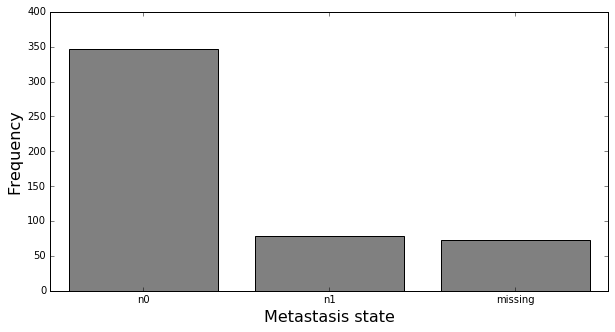

In [37]:
D = (('n0', y[y =='n0'].shape[0]), 
     ('n1', y[y =='n1'].shape[0]), 
     ('missing' , len(not_labeled)))
exp_fig = plt.figure(figsize=(10,5))
A = exp_fig.add_subplot(1,1,1)
ind = A.bar(range(0,3), height= [D[0][1], D[1][1], D[2][1]], align='center', color = 'grey')
A.set_xticks(range(0,3))
A.set_ylabel('Frequency', fontsize=16)
A.set_xlabel('Metastasis state', fontsize=16)
A.set_ylim(0,400)
A.set_xticklabels([D[0][0], D[1][0], D[2][0]])  #Must be a better way to do this...
ep = plt.show

#### Gene Activation (Gene counts) Dataset
The starting dataset, **'X_all'**, includes the transformed transcript per million (TPM) estimates for all RNA-seq profiles.  However some of the observations in this set do not have corresponding y_labels, as the clinical data set contains missing information.

Therefore X_all was trimmed to include only those observations where a finite y label exists, to yield **'X'**.  

In [38]:
"""Limit X to only observations where a target label is present."""
X = X_all.loc[set(y.index).intersection(X_all.index)]  #Only observations that also have a known metastasis state are kept.
y = y.loc[set(X.index).intersection(y.index)]
print("X dimensions:",X.shape,"\ny dimensions:",y.shape)

X dimensions: (424, 20501) 
y dimensions: (424,)


In [39]:
X_no_y = X_all.loc[list(not_labeled.index)]
print("Dimensions of unlabeled dataset:",X_no_y.shape)

Dimensions of unlabeled dataset: (73, 20501)


In [40]:
X.isnull().values.any()

False

### Exploratory Visualization

#### Gleason Score versus Metastasis analysis
The Gleason score is the gold-standard diagnostic test for cancer severity, but is not highly correlative with metastatic disease.  

In [41]:
clinical['gleasonscore'] = pd.to_numeric(clinical['gleasonscore'], errors= 'coerce')
clinical['gleasonscore'].isnull().any()

False

<function matplotlib.pyplot.show>

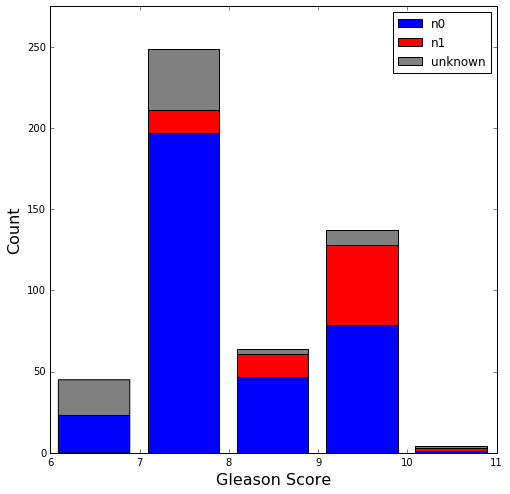

In [42]:
GS_hist = plt.figure(figsize=(8,8))
A = GS_hist.add_subplot(1,1,1)
sub = (('n1', ))

subs = [clinical.loc[y_all[y_all == 'n0'].index]['gleasonscore'],
        clinical.loc[y_all[y_all == 'n1'].index]['gleasonscore'],
        clinical.loc[y_all[y_all.isnull()].index]['gleasonscore']]

bins = [5.99, 6.99, 7.99, 8.99, 9.99, 10.99]
A.hist(subs, bins, label =['n0', 'n1', 'unknown'], color = ['blue','red','grey'], stacked = True)
A.set_ylim(0,275)
A.set_ylabel('Count', fontsize=16)
A.set_xlabel('Gleason Score', fontsize =16)
A.legend()
plt.show

### Test Train Split

In [43]:
from sklearn.model_selection import train_test_split


In [44]:
train_k = round(len(y)*0.75)
test_k = len(y) - train_k

In [45]:
seed = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size= test_k, 
                                                    train_size = train_k,
                                                    random_state = seed,
                                                    stratify = y)

### Benchmark 
#### Determine the Null Error / Accuracy Rates for Prediction
As the dataset is unbalanced, knowledge of the null rate - i.e. the performance measure given if a model were to predict the positive label indiscriminantly - is an important benchmark upon which to improve.  

In [46]:
from sklearn.metrics import matthews_corrcoef, fbeta_score, classification_report
from sklearn.model_selection import cross_val_score

In [47]:
"""Scorers needed throughout code:"""
from sklearn.metrics import make_scorer
matthews_cor_scorer = make_scorer(matthews_corrcoef, greater_is_better=True, needs_proba=False, needs_threshold=False)
fbeta_scorer = make_scorer(fbeta_score, greater_is_better=True, needs_proba=False, needs_threshold=False, pos_label='n1', beta = 2)

In [48]:
y_n1 = ['n1']*len(y)
print('Model predicts indiscriminantly, "n1"')
print('\nNull F beta: ', fbeta_score(y, y_n1, pos_label='n1',beta=2))
print('\nMCC: ',matthews_corrcoef(y, y_n1),"\n")
print(classification_report(y, y_n1, labels = ['n0','n1']))


Model predicts indiscriminantly, "n1"

Null F beta:  0.533783783784

MCC:  0.0 

             precision    recall  f1-score   support

         n0       0.00      0.00      0.00       345
         n1       0.19      1.00      0.31        79

avg / total       0.03      0.19      0.06       424



/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

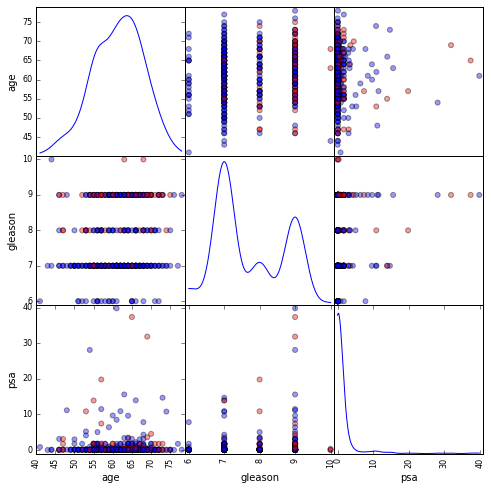

In [50]:
gleason = clinical['gleasonscore']
age = pd.to_numeric(clinical['yearstobirth'], errors = 'coerce')
age.fillna(value = np.mean(age), inplace=True)
psa = pd.to_numeric(clinical['psavalue'], errors= 'coerce')
psa.fillna(value = np.mean(psa), inplace =True)
gleason = gleason.loc[y.index]

benchmarkDF = pd.DataFrame({'gleason': gleason,
                            'age':age ,
                            'psa' : psa,
                            'y' : y}, index=X.index)

sm = pd.scatter_matrix(benchmarkDF, 
                       alpha=0.4, 
                       figsize= (8,8), 
                       diagonal = 'kde', 
                       c = benchmarkDF['y'].replace({'n1': 'red','n0':'blue'}), 
                       s = 100)

In [51]:
benchmarkDF.drop('y', axis=1, inplace = True)

<function matplotlib.pyplot.show>

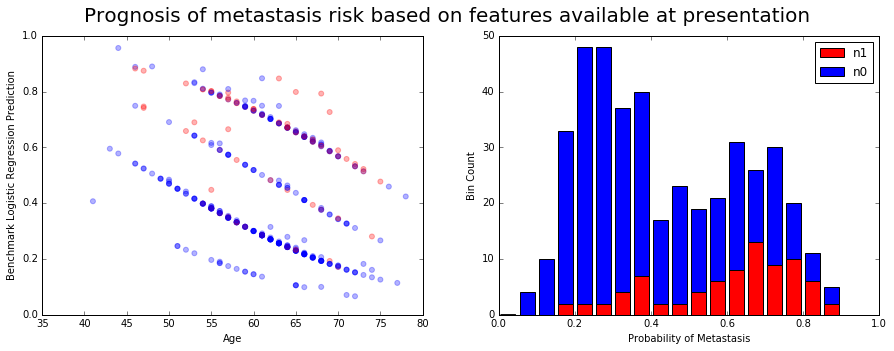

In [52]:
estimator = LogisticRegression(penalty='l2',
                              dual=False,
                              tol=0.0001,
                              C=1,
                              fit_intercept=True,
                              intercept_scaling=1,
                              class_weight='balanced',
                              random_state=123,
                              solver='liblinear',
                              max_iter=100,
                              multi_class='ovr',
                              verbose=0,
                              warm_start=False,
                              n_jobs=1)

clf = GridSearchCV(estimator,
                   param_grid = {'C': [1,0.1, 0.01, 0.001, 0.0001]},
                   scoring=fbeta_scorer,
                   fit_params=None,
                   n_jobs=1,
                   iid=True,
                   refit=True,
                   cv= 5,
                   verbose=0,
                   pre_dispatch='2*n_jobs',
                   error_score='raise')

clf.fit(benchmarkDF.loc[X_train.index, :], y_train)


bench_fig = plt.figure(figsize=(15,5))
A= bench_fig.add_subplot(1,2,1)
B = bench_fig.add_subplot(1,2,2)
A.scatter(benchmarkDF['age'], clf.predict_proba(benchmarkDF)[:,1], 
          color = y.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.3,
          s = 25)
A.set_ylabel('Benchmark Logistic Regression Prediction')
A.set_xlabel('Age')
plt.suptitle('Prognosis of metastasis risk based on features available at presentation', fontsize=20)

groups = [clf.predict_proba(benchmarkDF.loc[y[y=='n1'].index, :])[:,1], 
          clf.predict_proba(benchmarkDF.loc[y[y=='n0'].index, :])[:,1]]
bins = np.arange(0,1,0.05)
B.hist(groups, label =['n1', 'n0'],  bins = bins, color = ['red','blue'], stacked = True)
B.set_xlabel('Probability of Metastasis')
B.set_ylabel('Bin Count')
A.set_ylim(0,1)
B.legend()
#bench_fig.title("Prediction of Metastasis")
plt.show

In [53]:
"Benchmark Performance on Test dataset"
print('\nNull F beta: ', fbeta_score(y_test, clf.predict(benchmarkDF.loc[y_test.index, :]), pos_label='n1',beta=2))
print('\nMCC: ',matthews_corrcoef(y_test, clf.predict(benchmarkDF.loc[y_test.index, :])),"\n")
print(classification_report(y_test, clf.predict(benchmarkDF.loc[y_test.index, :]), labels = ['n0','n1']))



Null F beta:  0.495867768595

MCC:  0.211118166096 

             precision    recall  f1-score   support

         n0       0.88      0.66      0.75        86
         n1       0.29      0.60      0.39        20

avg / total       0.77      0.65      0.69       106



## Feature Reduction
### Univariate Feature that separate data labels

SelectKBest is a filtering function that utilizes a scoring function to filter a data set to the features that exhibit statistical difference when broken into class (metastasis state in this case).  This is a useful first step to remove all gene expression data where little difference in expression is observed between the two classes, as well as genes which are not expressed in either class, etc.  

In [54]:
from sklearn.feature_selection import SelectKBest, f_classif

In [55]:
K_selector = SelectKBest(f_classif, k = 'all')
K = K_selector.fit(X, y)

/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 1595  1815  2267  4324  4341  4342  4343  4344  4345  4346  4347  4779
  4780  4781  4782  4787  4790  4791  4794  4795  4801  4803  5259  6032
  6776  6780  6783  7445  7551  7632  7633  7634  7635  7636  7732  9275
  9277  9287  9291  9292  9419  9421  9423  9495 10092 11101 11929 12028
 12488 12527 12584 12593 12599 12601 12606 12635 12692 13749 13963 14015
 14129 14130 14131 14132 14726 14727 14729 15109 15111 15112 16536 16538
 16539 16541 16542 16543 16545 16546 16547 16548 16549 16550 16576 16605
 16608 16648 16668 16669 16670 16671 16672 16673 16674 16675 16676 16677
 16678 16679 16680 16681 16682 16683 16684 16685 16686 16687 16688 16689
 16690 16691 16692 16693 16694 16695 16696 16697 16698 16699 16700 16701
 16702 16703 16704 16705 16706 16707 16708 16709 16710 16711 16712 16713
 16714 16715 16716 16717 16718 16720 16721 16722 16723 16724 16725 

In [56]:
K_df = pd.DataFrame({'Gene':X.columns, 'F_score':K.scores_})
K_df.dropna(inplace=True)

<function matplotlib.pyplot.show>

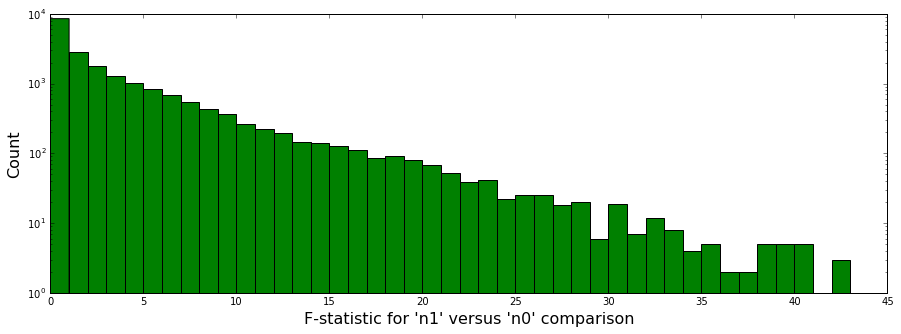

In [57]:
F_fig = plt.figure(figsize=(15,5))
A = F_fig.add_subplot(1,1,1)
A.hist(K_df['F_score'], bins=range(0,45,1), facecolor='green')
A.set_yscale('log')
A.set_ylabel('Count', fontsize=16)
A.set_xlabel("F-statistic for 'n1' versus 'n0' comparison", fontsize=16)
plt.show

## Scaling of Gene Count Data

In [58]:
from sklearn.preprocessing import MinMaxScaler

In [59]:
scaler = MinMaxScaler(feature_range= (-1,1), copy =False)
X_all = pd.DataFrame(scaler.fit_transform(X_all), columns = X_all.columns, index = [X_all.index])
X = X_all.loc[X.index]

In [60]:
"""Utilize the """
F_10 = 10
F_25 = 25
F_40 = 40

F_best = list(K_df[K_df['F_score'] > F_10]['Gene']) #Genes in which an F-score less than 10 are filtered out

X_k = X.loc[:,list(K_df[K_df['F_score'] > F_10]['Gene'])]
print("New Dataset, X_k, has shape:",X_k.shape)

X_kk = X.loc[:,list(K_df[K_df['F_score'] > F_25]['Gene'])]
print("New Dataset, X_kk, has shape:",X_kk.shape)

X_k40 = X.loc[:,list(K_df[K_df['F_score'] > F_40]['Gene'])]
print("New Dataset, X_k40, has shape:",X_k40.shape)



New Dataset, X_k, has shape: (424, 1863)
New Dataset, X_kk, has shape: (424, 175)
New Dataset, X_k40, has shape: (424, 12)


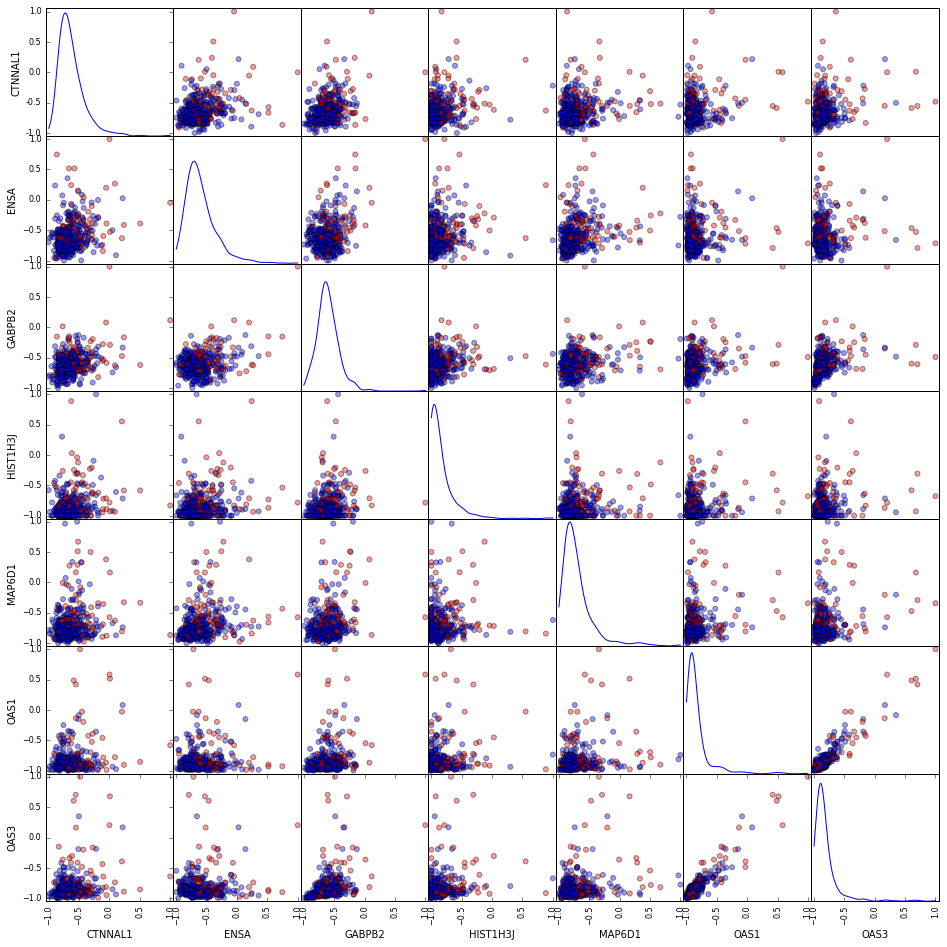

In [69]:
sm = pd.scatter_matrix(X_k40.iloc[:,0:7], 
                       alpha=0.4, 
                       figsize= (16,16), 
                       diagonal = 'kde', 
                       c = y.replace({'n1': 'red','n0':'blue'}), 
                       s = 100)

## Generate Models

The data is noisy...

An ensemble model is usually the most appropriate.  

### Random Forest

In [38]:
%run -i Random_Forest/RF.py

RandomForestClassifier(bootstrap=True, class_weight={'n0': 1, 'n1': 8},
            criterion='gini', max_depth=3, max_features=25,
            max_leaf_nodes=None, min_samples_leaf=30, min_samples_split=75,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

              precision    recall  f1-score   support

         n0       0.99      0.72      0.83       259
         n1       0.44      0.97      0.61        59

avg / total       0.89      0.77      0.79       318


F beta:  0.780821917808

MCC:  0.544763036449


## Test for the best model

In [39]:
import math

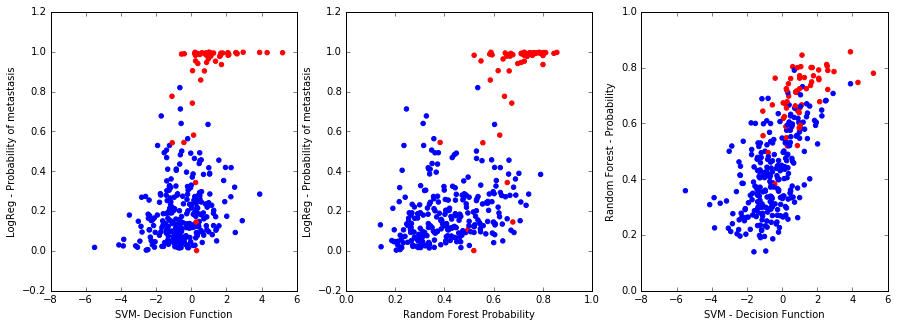

In [59]:
FIG = plt.figure(figsize=(15,5))
A = FIG.add_subplot(1,3,1)
A.scatter(clf_svm_fr.decision_function(X_FR.loc[X_train.index]),
          LR_clf.predict_proba(logisticDF_train)[:,1],
          color = y_train.replace({'n0': 'blue', 'n1':'red'}))
A.set_xlabel('SVM- Decision Function')
A.set_ylabel('LogReg - Probability of metastasis')
B = FIG.add_subplot(1,3,2) 
B.scatter(RF_clf.predict_proba(X_k.loc[X_train.index])[:,1],
          LR_clf.predict_proba(logisticDF_train)[:,1],
          color = y_train.replace({'n0': 'blue', 'n1':'red'}))
B.set_ylabel('LogReg - Probability of metastasis')
B.set_xlabel('Random Forest Probability')
C = FIG.add_subplot(1,3,3)
C.scatter(clf_svm_fr.decision_function(X_FR.loc[X_train.index]),
          RF_clf.predict_proba(X_k.loc[X_train.index])[:,1],
          color = y_train.replace({'n0': 'blue', 'n1':'red'}))
C.set_ylabel('Random Forest - Probability')
C.set_xlabel('SVM - Decision Function')
plt.show()

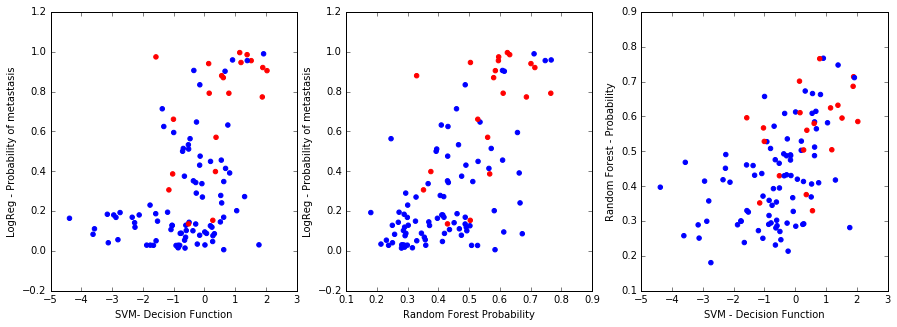

In [60]:
FIG = plt.figure(figsize=(15,5))
A = FIG.add_subplot(1,3,1)
A.scatter(clf_svm_fr.decision_function(X_FR.loc[X_test.index]),
          LR_clf.predict_proba(logisticDF_test)[:,1],
          color = y_test.replace({'n0': 'blue', 'n1':'red'}))
A.set_xlabel('SVM- Decision Function')
A.set_ylabel('LogReg - Probability of metastasis')
B = FIG.add_subplot(1,3,2) 
B.scatter(RF_clf.predict_proba(X_k.loc[X_test.index])[:,1],
          LR_clf.predict_proba(logisticDF_test)[:,1],
          color = y_test.replace({'n0': 'blue', 'n1':'red'}))
B.set_ylabel('LogReg - Probability of metastasis')
B.set_xlabel('Random Forest Probability')
C = FIG.add_subplot(1,3,3)
C.scatter(clf_svm_fr.decision_function(X_FR.loc[X_test.index]),
          RF_clf.predict_proba(X_k.loc[X_test.index])[:,1],
          color = y_test.replace({'n0': 'blue', 'n1':'red'}))
C.set_ylabel('Random Forest - Probability')
C.set_xlabel('SVM - Decision Function')

plt.show()

In [61]:
print(classification_report(y_test,
                            clf_svm_fr.predict(X_FR.loc[X_test.index]),
                            target_names = ['n0', 'n1']))
print('F beta: ', fbeta_score(y_test, clf_svm_fr.predict(X_FR.loc[X_test.index]), beta = 2, pos_label='n1'))
print('\nMCC: ',matthews_corrcoef(y_test, clf_svm_fr.predict(X_FR.loc[X_test.index])))

             precision    recall  f1-score   support

         n0       0.92      0.70      0.79        86
         n1       0.37      0.75      0.49        20

avg / total       0.82      0.71      0.74       106

F beta:  0.619834710744

MCC:  0.359648203306


In [62]:
print(classification_report(y_test,
                            RF_clf.predict(X_k.loc[X_test.index]),
                            target_names = ['n0', 'n1']))
print('F beta: ', fbeta_score(y_test, RF_clf.predict(X_k.loc[X_test.index]), beta = 2, pos_label='n1'))
print('\nMCC: ',matthews_corrcoef(y_test, RF_clf.predict(X_k.loc[X_test.index])))

             precision    recall  f1-score   support

         n0       0.94      0.76      0.84        86
         n1       0.43      0.80      0.56        20

avg / total       0.85      0.76      0.79       106

F beta:  0.683760683761

MCC:  0.45621363541


In [63]:
print(classification_report(y_test,
                            LR_clf.predict(logisticDF_test),
                            target_names = ['n0', 'n1']))
print('F beta: ', fbeta_score(y_test, LR_clf.predict(logisticDF_test), beta = 2, pos_label='n1'))
print('\nMCC: ',matthews_corrcoef(y_test, LR_clf.predict(logisticDF_test)))

             precision    recall  f1-score   support

         n0       0.93      0.81      0.87        86
         n1       0.48      0.75      0.59        20

avg / total       0.85      0.80      0.82       106

F beta:  0.675675675676

MCC:  0.48506063637


## Generate a Voting Classifier and Test for performance

In [45]:
clf_dict = {'SVM' : {'model': clf_svm_fr, 
                          'input_set': X_FR.loc[X_train.index,:], 
                          'label_set' : y_train, 
                          'weight' : 1}, 
            'Random_Forest' : {'model': RF_clf, 
                          'input_set': X_k.loc[X_train.index], 
                          'label_set' : y_train, 
                          'weight' : 1}, 
            'LogReg' : {'model': LR_clf, 
                          'input_set': logisticDF_train, 
                          'label_set' : y_train, 
                          'weight' : 1}}
test_dict = {'SVM' : {'model': clf_svm_fr, 
                          'input_set':X_FR.loc[X_test.index,:], 
                          'label_set' : y_test, 
                          'weight' : 1}, 
            'Random_Forest' : {'model': RF_clf, 
                          'input_set': X_k.loc[X_test.index], 
                          'label_set' : y_test, 
                          'weight' : 1}, 
            'LogReg' : {'model': LR_clf, 
                          'input_set': logisticDF_test, 
                          'label_set' : y_test, 
                          'weight' : 1}}

In [64]:
import math
def voter(clf_dict, threshold=0.5, verbose = True) :
    """Test labels are in same order"""
    pass
    
    df = pd.DataFrame()
    weights = []
    for model in clf_dict.items() :
        if model[0] == 'SVM'  :
            df[model[0]] = model[1]['model'].decision_function(model[1]['input_set'])  ##This could scale the decision dramatically both negative and positive directions
            df[model[0]] = df[model[0]].apply(lambda x : 1 / (1 + math.exp(-2*(x - 0))))
        else :
            df[model[0]] = model[1]['model'].predict_proba(model[1]['input_set'])[:,1]
        df[model[0]] = df[model[0]].apply(lambda x : x*model[1]['weight'])
        weights.append(model[1]['weight'])
    df.set_index(clf_dict['LogReg']['label_set'].index, inplace=True)
    #print(weights)
    df['Weighted_Vote'] = df.apply(lambda x : sum(x)/np.sum(weights), axis = 1)
    df['actual_y'] = list(clf_dict['LogReg']['label_set'])
    df['called_y'] = df['Weighted_Vote'].apply(lambda x : x >= threshold)
    df['called_y'] = df['called_y'].replace({False : 'n0', True : 'n1'})
    #print(df.tail(10)) #[Debug]
    if verbose == True :
        print('\nClass_report:\n ',classification_report(df['actual_y'], df['called_y']))
        print('\nF beta: ',fbeta_score(df['actual_y'], df['called_y'], beta = 2, pos_label='n1'))
        print('\nMCC: ',matthews_corrcoef(df['actual_y'], df['called_y']))
    return(fbeta_score(df['actual_y'], df['called_y'], beta = 2, pos_label='n1'),
           matthews_corrcoef(df['actual_y'], df['called_y']))


In [65]:
F2_train, MCC_train = voter(clf_dict, 0.5, verbose=True)


Class_report:
               precision    recall  f1-score   support

         n0       0.97      0.84      0.90       259
         n1       0.56      0.90      0.69        59

avg / total       0.90      0.85      0.86       318


F beta:  0.800604229607

MCC:  0.62520694657


In [66]:
"""Find appropriate voting threshold"""
#TH = pd.DataFrame(columns= ['Threshold', 'F2'])
temp_list = []
for x in np.arange(0, .99, 0.04) :
    temp_list.append({'Threshold': x, 'F2': voter(clf_dict, x, verbose=False)[0], 'MCC':voter(clf_dict, x, verbose=False)[1] })

Train_TH = pd.DataFrame(temp_list, columns = ['Threshold', 'F2', 'MCC'])

temp_list = []
for x in np.arange(0.01, 1, 0.02) :
    temp_list.append({'Threshold': x, 'F2': voter(test_dict, x, verbose=False)[0], 'MCC':voter(test_dict, x, verbose=False)[1] })

Test_TH = pd.DataFrame(temp_list, columns = ['Threshold', 'F2', 'MCC'])
    

/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<function matplotlib.pyplot.show>

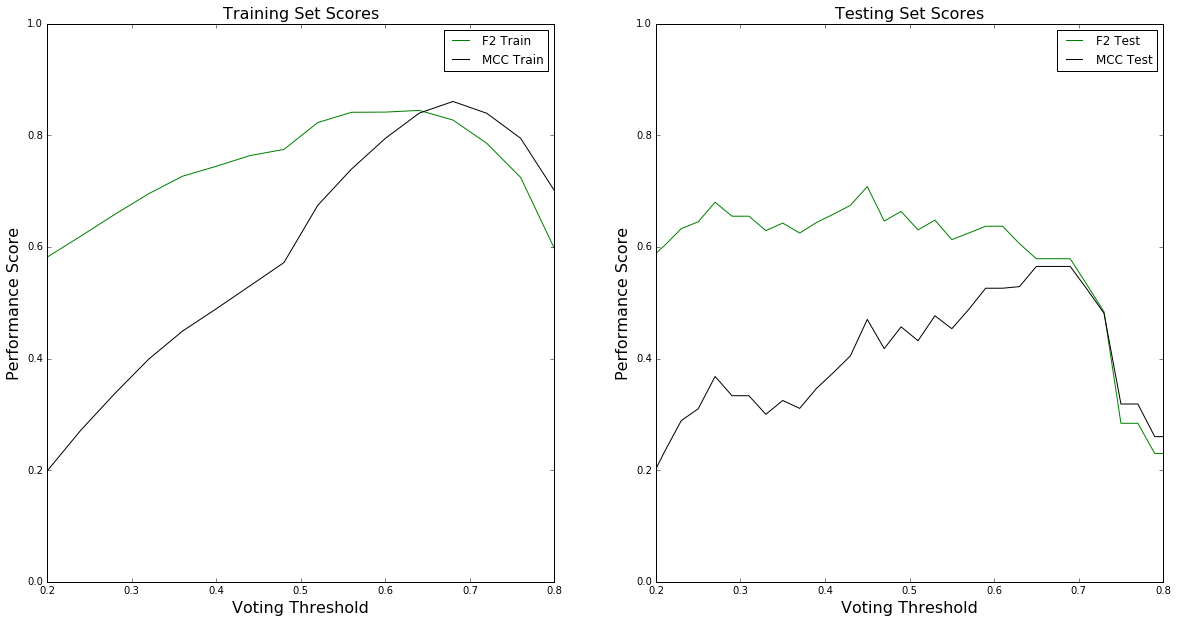

In [67]:
TH_fig = plt.figure(figsize=(20,10))
A = TH_fig.add_subplot(1,2,1)
B = TH_fig.add_subplot(1,2,2)
A.plot(Train_TH['Threshold'], Train_TH['F2'], color = 'green', label='F2 Train')
A.plot(Train_TH['Threshold'], Train_TH['MCC'], color = 'black', label = 'MCC Train')
B.plot(Test_TH['Threshold'], Test_TH['F2'], color = 'green', label = 'F2 Test')
B.plot(Test_TH['Threshold'], Test_TH['MCC'], color = 'black', label = 'MCC Test')
A.legend(loc='best')
B.legend()
A.set_ylim(0,1)
A.set_xlim(.2,.8)
B.set_ylim(0,1)
B.set_xlim(.2,.8)
A.set_title('Training Set Scores', fontsize=16)
B.set_title('Testing Set Scores', fontsize=16)
A.set_ylabel('Performance Score', fontsize=16)
B.set_ylabel('Performance Score', fontsize=16)
A.set_xlabel('Voting Threshold', fontsize=16)
B.set_xlabel('Voting Threshold', fontsize=16)
plt.show
    

In [68]:
F2, MCC = voter(test_dict, threshold=0.50, verbose=True)


Class_report:
               precision    recall  f1-score   support

         n0       0.92      0.80      0.86        86
         n1       0.45      0.70      0.55        20

avg / total       0.83      0.78      0.80       106


F beta:  0.630630630631

MCC:  0.432054010127


##### 